In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

from torch import nn
import neural_network
import losses
import torch

In [2]:
df = pd.read_csv("clean2_data-ext-norm.csv", index_col=0)

(array([244404.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  20490.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

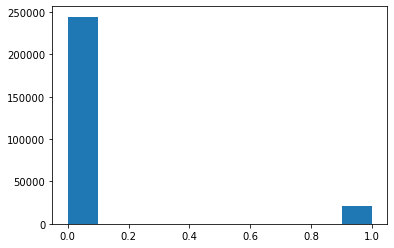

In [6]:
plt.hist(df["TARGET"])

[Text(0.5, 1.0, 'Distribution of Class Labels')]

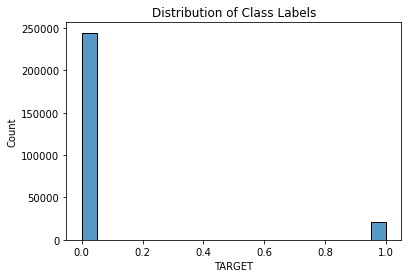

In [7]:
sns.histplot(data=df, x="TARGET").set(title='Distribution of Class Labels')

In [8]:
seed = 100
test_size = 0.15
X = df.drop(columns=["TARGET", "SK_ID_CURR"], axis=1)
y = df["TARGET"]

# note: stratify=df.buy generates
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

[Text(0.5, 1.0, 'Distribution of Training Class Labels')]

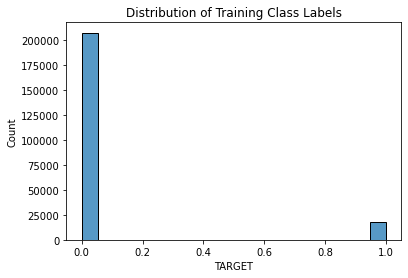

In [10]:
sns.histplot(data=y_train).set(title='Distribution of Training Class Labels')

[Text(0.5, 1.0, 'Distribution of Testing Class Labels')]

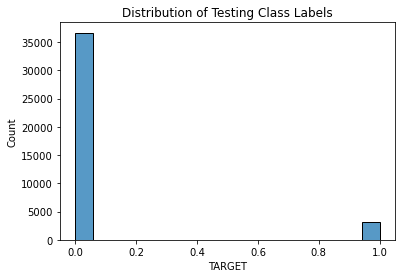

In [11]:
sns.histplot(data=y_test).set(title='Distribution of Testing Class Labels')